In [47]:
from pyDeepInsight import ImageTransformer
from pyDeepInsight.utils import Norm2Scaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np
import scanpy as sc

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import label_binarize
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
from sklearn.metrics import (
    precision_score, recall_score, f1_score, roc_auc_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
)


In [48]:


expr_file = "data/Smartseq2_upperlim_gbm_data.h5ad"
adata = sc.read_h5ad(expr_file)
X = adata.X.toarray() if hasattr(adata.X, "toarray") else adata.X
y = adata.obs["tumour name"].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y)
np.unique(y, return_counts=True)

(array(['BT1160', 'BT1187', 'BT749', 'BT771', 'BT786', 'BT830', 'BT920',
        'MGH100', 'MGH101', 'MGH102', 'MGH104', 'MGH105', 'MGH106',
        'MGH110', 'MGH113', 'MGH115', 'MGH121', 'MGH122', 'MGH124',
        'MGH125', 'MGH128', 'MGH129', 'MGH136', 'MGH143', 'MGH151',
        'MGH152', 'MGH66', 'MGH85'], dtype=object),
 array([260, 200, 221, 186, 124, 167, 296, 136, 166, 262, 260, 505, 156,
        272, 229,  94, 254, 165, 251, 313,  65, 144, 180, 248, 136, 117,
        358, 170]))

In [49]:
ln = Norm2Scaler()
X_train_norm = ln.fit_transform(X_train)
X_test_norm = ln.transform(X_test)


le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)
num_classes = np.unique(y_train_enc).size

In [50]:
distance_metric = 'cosine'
reducer = TSNE(
    n_components=2,
    metric=distance_metric,
    init='random',
    learning_rate='auto',
    n_jobs=-1
)

In [51]:
pixel_size = (227,227)
it = ImageTransformer(
    feature_extractor=reducer, 
    pixels=pixel_size)

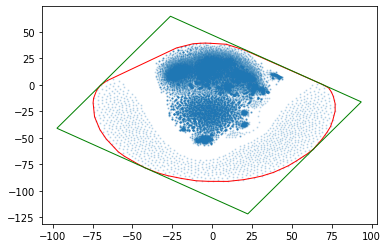

In [52]:
it.fit(X_train_norm, y=y_train, plot=True)
X_train_img = it.transform(X_train_norm)
X_test_img = it.transform(X_test_norm)

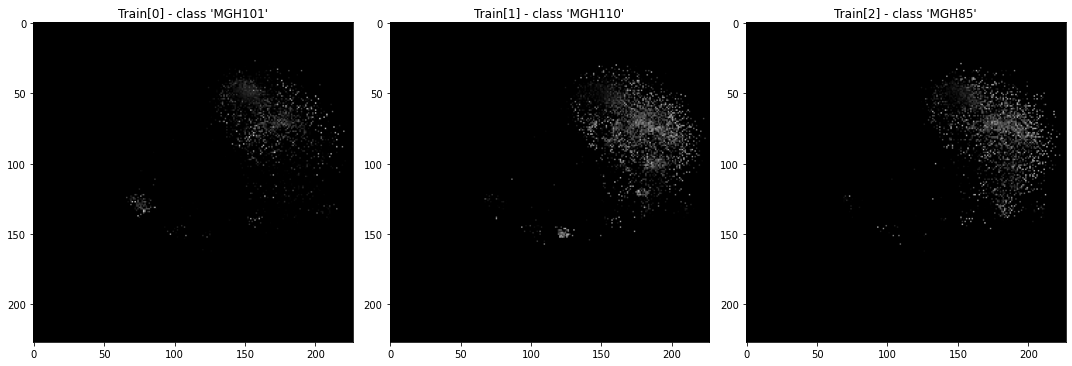

In [53]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i in range(0,3):
    ax[i].imshow(X_train_img[i])
    ax[i].title.set_text(f"Train[{i}] - class '{y_train[i]}'")
plt.tight_layout()

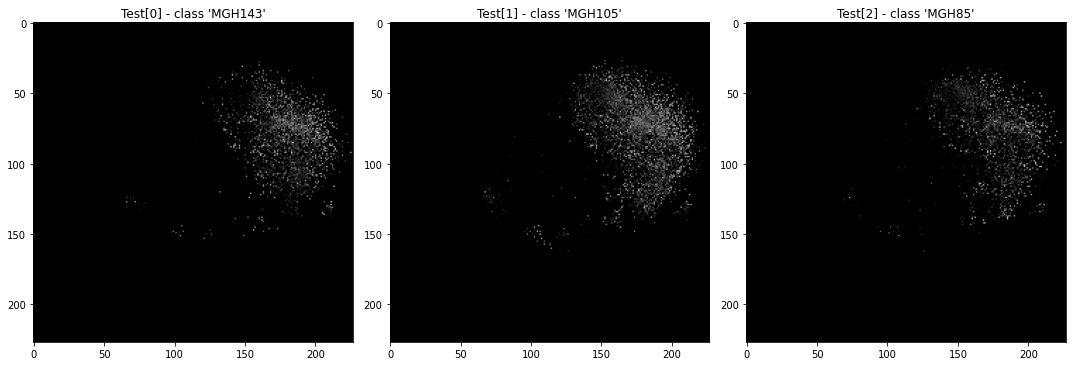

In [54]:

X_test_img = it.transform(X_test_norm)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i in range(0,3):
    ax[i].imshow(X_test_img[i])
    ax[i].title.set_text(f"Test[{i}] - class '{y_test[i]}'")
plt.tight_layout()

In [55]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [56]:
model = torchvision.models.squeezenet1_1(weights='DEFAULT')
model.features[0] = nn.Conv2d(1, 64, kernel_size=3, stride=2)  # Modify input layer for 1 channel
model.classifier.append(nn.Flatten())
_ = model.classifier.append(nn.Linear(1000, num_classes))


In [57]:
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x[:1])  # ensure single channel
])



In [58]:
y_train_tensor = torch.from_numpy(le.transform(y_train)).long()
y_test_tensor = torch.from_numpy(le.transform(y_test)).long()


In [59]:
# Define custom Dataset
from torch.utils.data import Dataset, DataLoader

class DeepInsightDataset(Dataset):
    def __init__(self, images, labels, transform):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.transform(self.images[idx]).float()  # <-- force float32
        label = self.labels[idx]
        return img, label

# Create datasets and loaders
train_dataset = DeepInsightDataset(X_train_img, y_train_tensor, preprocess)
test_dataset = DeepInsightDataset(X_test_img, y_test_tensor, preprocess)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)




In [60]:
batch_size = 200

train_dataset = DeepInsightDataset(X_train_img, y_train_tensor, preprocess)
test_dataset = DeepInsightDataset(X_test_img, y_test_tensor, preprocess)

trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [61]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(
    model.parameters(),
    lr=1e-04,
    #momentum=0.8,
    weight_decay=1e-05
)

In [62]:
model.train()
model.to(device)
for epoch in range(100):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    # print epoch statistics
    if not (epoch % 20):
        print(f'[{epoch}] loss: {running_loss / len(train_dataset) * batch_size:.3f}')
print(f'[{epoch}] loss: {running_loss / len(train_dataset) * batch_size:.3f}')


[0] loss: 3.347
[20] loss: 1.443
[40] loss: 0.968
[60] loss: 0.694
[80] loss: 0.476
[99] loss: 0.353


In [63]:
model.to('cpu')
model = model.eval()

In [64]:
train_predicted = []
y_true_train = []

with torch.no_grad():
    for inputs, labels in trainloader:
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)
        train_predicted.append(preds)
        y_true_train.append(labels)

train_predicted = torch.cat(train_predicted)
y_true_train = torch.cat(y_true_train)

# Accuracy
train_accuracy = accuracy_score(y_true_train.numpy(), train_predicted.numpy())
print("Training Accuracy:", train_accuracy)


Training Accuracy: 0.9106992417860151


In [65]:
test_predicted = []
y_true_test = []

with torch.no_grad():
    for inputs, labels in testloader:
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)
        test_predicted.append(preds)
        y_true_test.append(labels)

test_predicted = torch.cat(test_predicted)
y_true_test = torch.cat(y_true_test)


In [66]:
import torch.nn.functional as F
probs_test = []

with torch.no_grad():
    for inputs, _ in testloader:
        outputs = model(inputs)
        probs = F.softmax(outputs, dim=1)
        probs_test.append(probs)

probs_test = torch.cat(probs_test).numpy()


Training Accuracy: 0.9107
Test Accuracy: 0.7043
Precision (Macro): 0.7017
Precision (Micro): 0.7043
Precision (Weighted): 0.7227
Recall (Macro): 0.6768
Recall (Micro): 0.7043
Recall (Weighted): 0.7043
F1-score (Macro): 0.6789
F1-score (Micro): 0.7043
F1-score (Weighted): 0.7039
ROC-AUC (OvO, Macro): 0.9735
ROC-AUC (OvO, Weighted): 0.9746
ROC-AUC (OvR, Macro): 0.9735
ROC-AUC (OvR, Weighted): 0.9746

Classification Report:
              precision    recall  f1-score   support

      BT1160       0.87      0.65      0.75        52
      BT1187       0.59      0.88      0.71        40
       BT749       1.00      0.91      0.95        44
       BT771       0.65      0.46      0.54        37
       BT786       0.85      0.92      0.88        25
       BT830       0.80      1.00      0.89        33
       BT920       0.88      0.88      0.88        59
      MGH100       0.46      0.44      0.45        27
      MGH101       0.86      0.94      0.90        33
      MGH102       0.71      0.65 

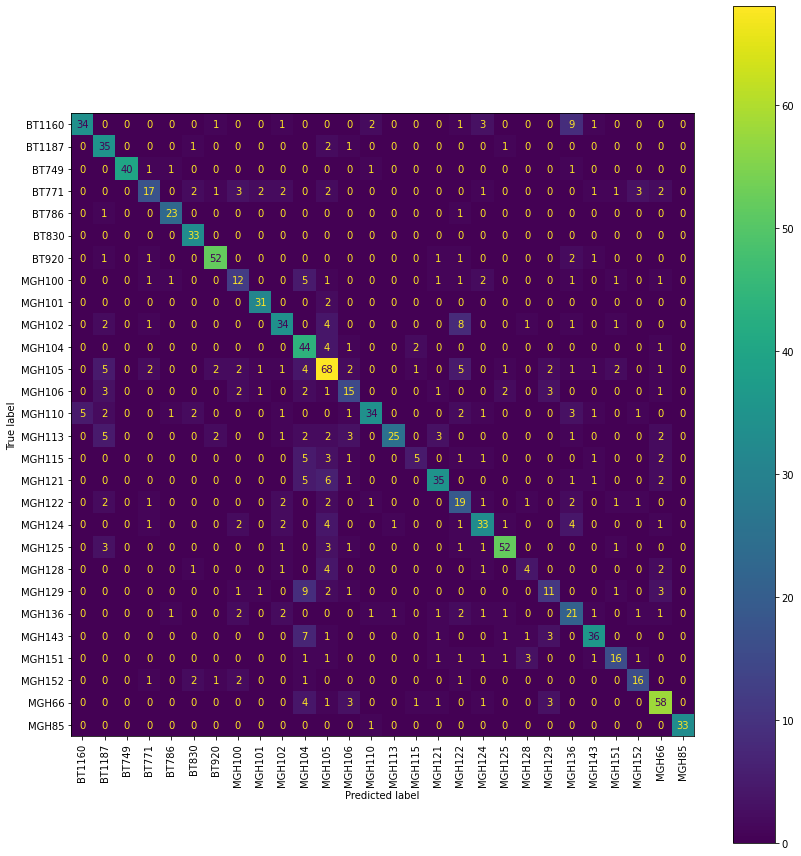

In [68]:


# === Metrics ===
y_true = y_test_tensor.cpu().numpy()
y_pred = test_predicted.cpu().numpy()
y_true_onehot = label_binarize(y_true, classes=np.arange(num_classes))

precision_macro = precision_score(y_true, y_pred, average='macro')
precision_micro = precision_score(y_true, y_pred, average='micro')
precision_weighted = precision_score(y_true, y_pred, average='weighted')

recall_macro = recall_score(y_true, y_pred, average='macro')
recall_micro = recall_score(y_true, y_pred, average='micro')
recall_weighted = recall_score(y_true, y_pred, average='weighted')

f1_macro = f1_score(y_true, y_pred, average='macro')
f1_micro = f1_score(y_true, y_pred, average='micro')
f1_weighted = f1_score(y_true, y_pred, average='weighted')

roc_auc_ovo_macro = roc_auc_score(y_true_onehot, probs_test, multi_class='ovo', average='macro')
roc_auc_ovo_weighted = roc_auc_score(y_true_onehot, probs_test, multi_class='ovo', average='weighted')
roc_auc_ovr_macro = roc_auc_score(y_true_onehot, probs_test, multi_class='ovr', average='macro')
roc_auc_ovr_weighted = roc_auc_score(y_true_onehot, probs_test, multi_class='ovr', average='weighted')

train_accuracy = accuracy_score(y_true_train.numpy(), train_predicted.numpy())
test_accuracy = accuracy_score(y_true, y_pred)

report = classification_report(y_true, y_pred, target_names=le.classes_)

# === Print Results ===
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Precision (Macro): {precision_macro:.4f}")
print(f"Precision (Micro): {precision_micro:.4f}")
print(f"Precision (Weighted): {precision_weighted:.4f}")
print(f"Recall (Macro): {recall_macro:.4f}")
print(f"Recall (Micro): {recall_micro:.4f}")
print(f"Recall (Weighted): {recall_weighted:.4f}")
print(f"F1-score (Macro): {f1_macro:.4f}")
print(f"F1-score (Micro): {f1_micro:.4f}")
print(f"F1-score (Weighted): {f1_weighted:.4f}")
print(f"ROC-AUC (OvO, Macro): {roc_auc_ovo_macro:.4f}")
print(f"ROC-AUC (OvO, Weighted): {roc_auc_ovo_weighted:.4f}")
print(f"ROC-AUC (OvR, Macro): {roc_auc_ovr_macro:.4f}")
print(f"ROC-AUC (OvR, Weighted): {roc_auc_ovr_weighted:.4f}")
print("\nClassification Report:")
print(report)

fig, ax = plt.subplots(figsize=(12, 12))  # Make it large
disp = ConfusionMatrixDisplay.from_predictions(
    y_true, y_pred, display_labels=le.classes_, ax=ax, xticks_rotation=90
)
plt.tight_layout()
plt.show()